<a href="https://colab.research.google.com/github/nikishkaaa/ML-Course/blob/main/HW_2_5_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [145]:
!pip install darts --quiet

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import scipy.stats as stats
from darts.utils.statistics import plot_residuals_analysis
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveSeasonal, NaiveDrift
from darts.metrics import mape

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
data_raw = pd.read_csv('TimeSeries_data.csv')
data_raw['date'] = pd.to_datetime(data_raw['date'])

data = data_raw.copy()
data.set_index('date', inplace=True)
data.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [4]:
daily_sales = data_raw.groupby('date', as_index=False)['sales'].sum()
item_daily_sales = data_raw.groupby(['item', 'date'], as_index=False)['sales'].sum()
store_item_sales = data_raw.groupby(['store', 'item'], as_index=False)['sales'].sum()
store_daily_sales = data_raw.groupby(['store', 'date'], as_index=False)['sales'].sum()

In [5]:
fig1 = px.line(item_daily_sales, x='date', y='sales', color='item',
                title='Sales Dynamics by Item')
fig1.show()

In [6]:
fig2 = px.bar(store_item_sales, x='store', y='sales', color='item',
               title='Sales by Store for Each Item',
               barmode='group')
fig2.show()

In [7]:
fig3 = px.area(daily_sales, x='date', y='sales',
                title='Daily Sales in all stores')
fig3.show()

In [8]:
fig4 = px.line(store_daily_sales, x='date', y='sales', color='store',
                title='Sales Dynamics by Store')
fig4.show()

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [9]:
## store1 + item1
df = data[(data['item'] == 1) & (data['store'] == 1)]

In [10]:
df.head(2)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11


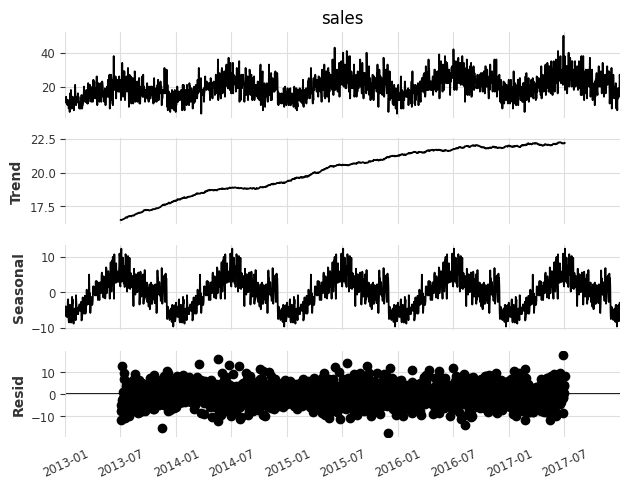

In [11]:
df_additive = seasonal_decompose(df['sales'], model = 'additive', period=365)
df_additive.plot()
plt.xticks(rotation=25)
plt.show()

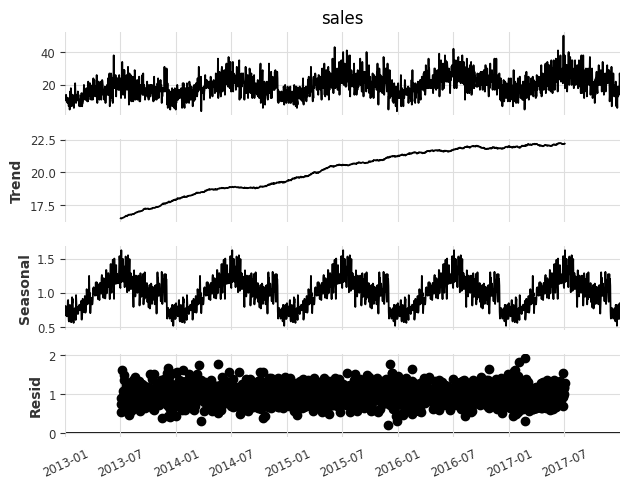

In [12]:
df_multi = seasonal_decompose(df['sales'], model = 'multiplicative', period=365)
df_multi.plot()
plt.xticks(rotation=25)
plt.show()

Висновок:
- Графік продажів показує, що ряд досить варіабельний з постійними коливаннями протягом усього періоду.
- Часовий ряд має висхідний тренд.
- Продажі мають сезонність.
- Залишки представляють шум або випадкові варіації, які не можуть бути пояснені трендом або сезонністю.

#### Аналіз залишків

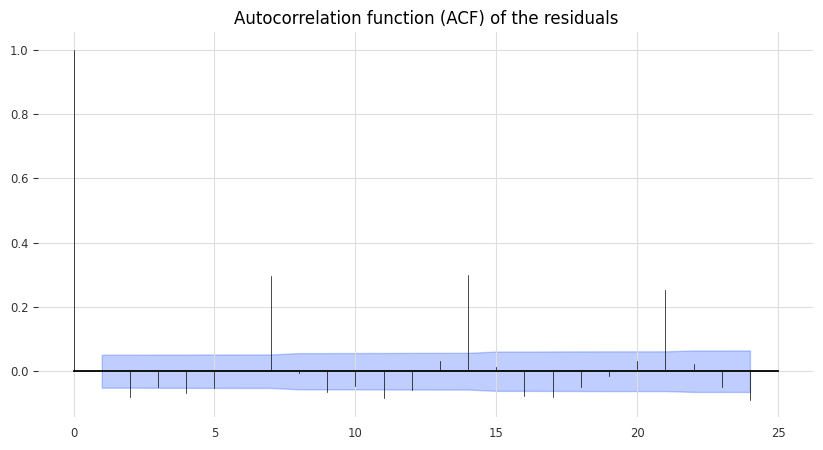

In [13]:
residuals = df_additive.resid.dropna()
residuals_ts = TimeSeries.from_dataframe(pd.DataFrame(residuals))
plot_acf(residuals_ts)
plt.title('Autocorrelation function (ACF) of the residuals')
plt.show()

W-stats: 0.998730099016241, p-value: 0.3774649394825057


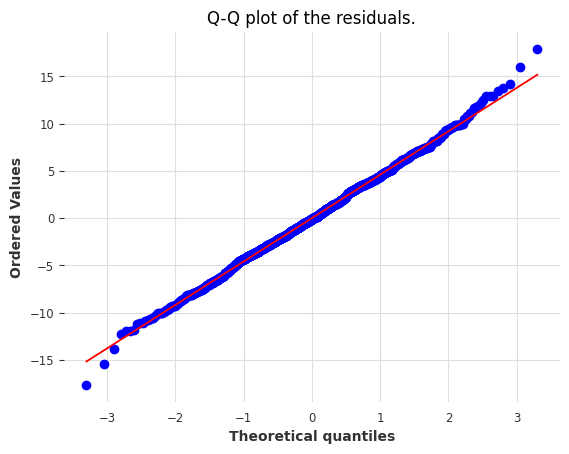

In [14]:
# Тест Шапіро-Вілка
stat, p_value = shapiro(df_additive.resid.dropna())
print(f'W-stats: {stat}, p-value: {p_value}')

# Q-Q графік для залишків
stats.probplot(df_additive.resid.dropna(), dist="norm", plot=plt)
plt.title('Q-Q plot of the residuals.')
plt.show()

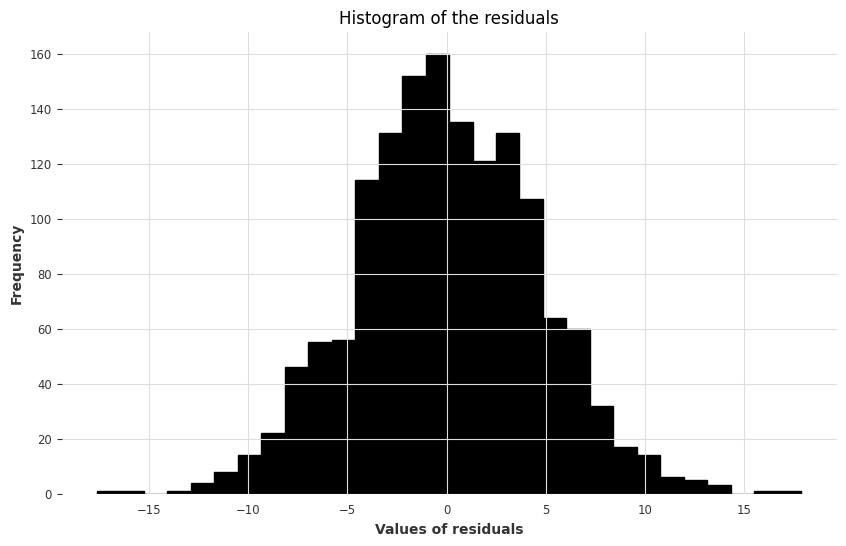

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(df_additive.resid.dropna(), bins=30, edgecolor='k')
plt.title('Histogram of the residuals')
plt.xlabel('Values of residuals')
plt.ylabel('Frequency')

plt.show()

Висновок: з графіка функції автокореляції бачимо, що автокореляція для деяких лагів за довірчим діапазоном, отже певна залежність залишків існує. Але інші графіки показують нормальній розподіл залишків. Отже, можемо вважати, що адативна модель добре описує дані

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [16]:
time_df = TimeSeries.from_dataframe(df, value_cols = 'sales')
time_df

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

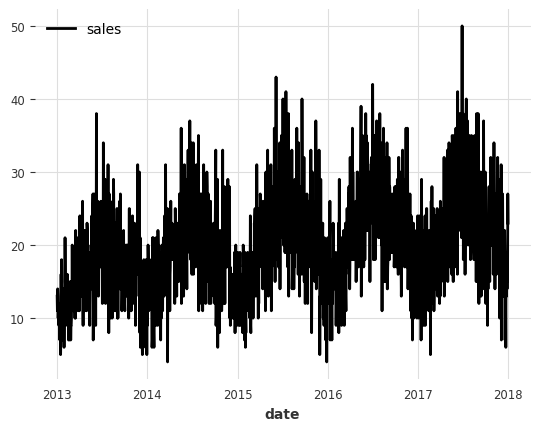

In [17]:
time_df.plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

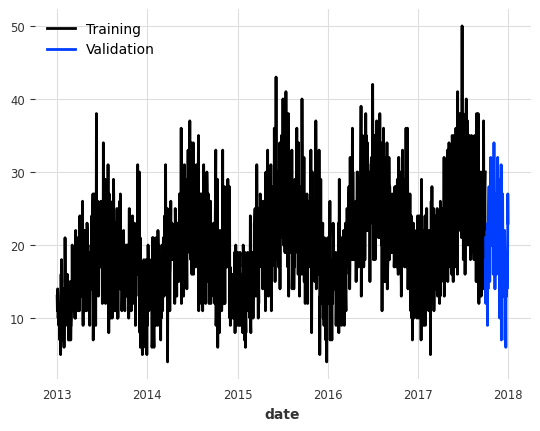

In [18]:
train, val = time_df.split_before(pd.Timestamp("2017-10-01"))
train.plot(label = 'Training')
val.plot(label = 'Validation')

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [19]:
time_df

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [20]:
df = df['sales']

<Figure size 1000x600 with 0 Axes>

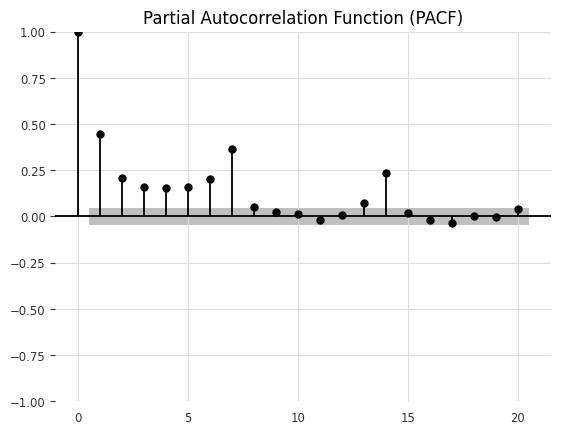

In [21]:
# Візуалізація часткової автокореляційної функції (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(df, lags=20, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Висновок: значущі значення на наступних лагах показують, що кореляція на цих лагах залишається значущою, навіть усунувши вплив проміжних лагів.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

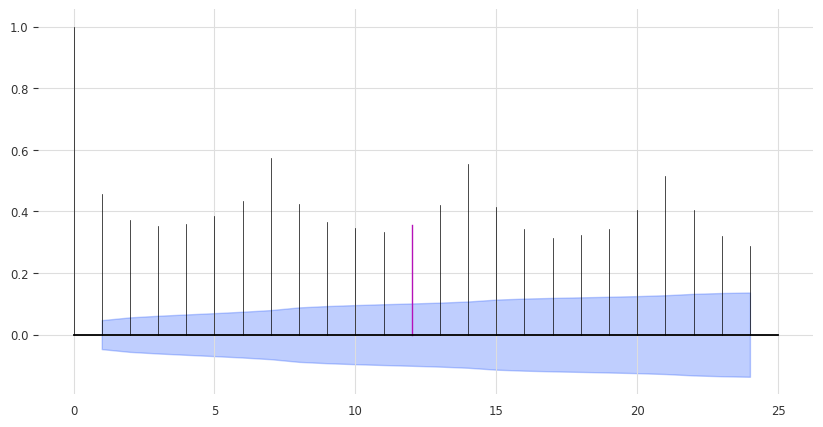

In [22]:
plot_acf(train, m=12, alpha=0.05, max_lag=24)

In [23]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


In [24]:
# Перевірка сезонності для тренувального ряду
is_seasonal, period = check_seasonality(train, max_lag=365)

if is_seasonal:
    print(f"Ряд є сезонним з періодом {period}.")
else:
    print("Сезонність не виявлена.")

Ряд є сезонним з періодом 7.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [33]:
def mape_calc(series, forecast):
        print(
            f"Mean absolute percentage error: {mape(series, forecast):.2f}%."
        )

<Axes: xlabel='date'>

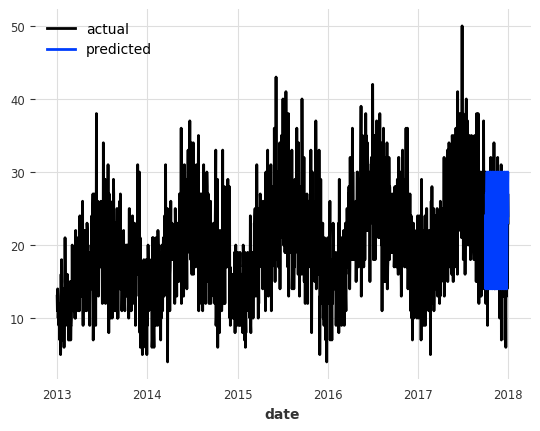

In [25]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
naive_forecast = seasonal_model.predict(len(val))

time_df.plot(label='actual')
naive_forecast.plot(label='predicted')

In [35]:
mape_calc(time_df, naive_forecast)

Mean absolute percentage error: 38.17%.


Висновок: модель NaiveSeasonal працює погано, не враховує тренд

# Не работает !!!

<Axes: xlabel='date'>

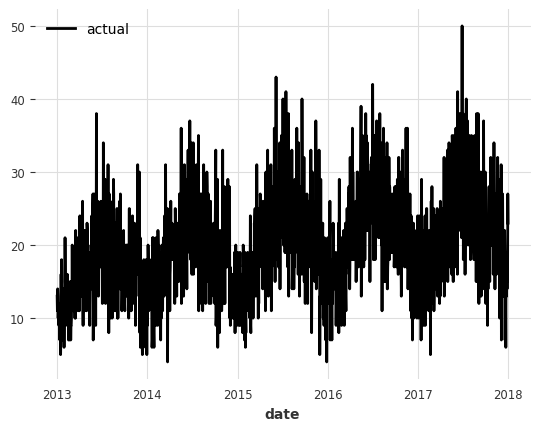

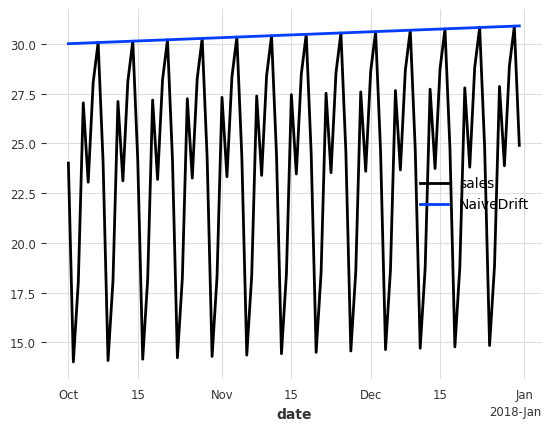

In [40]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_preds = drift_model.predict(len(val))

combined = drift_preds+ naive_forecast - train.last_value()

time_df.plot(label='actual')
combined.plot('combined')
drift_preds.plot(label='NaiveDrift')

In [34]:
mape_calc(time_df, combined)

Mean absolute percentage error: 39.91%.


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

14. Натренуйте модель Prophet та зробіть висновок про її якість.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.